# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import datetime
import pickle
import matplotlib.pyplot as plt


In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

In [3]:
# explore the offers
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
def wrangle_portfolio(portfolio):
    '''
    Clean and wrangle the portfolio dataframe
    
    INPUT:
    portfolio - the dataframe to be cleaned and wrangled
    
    OUTPUT:
    portfolio - the cleaned and wrangled portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    
    
    # Encoding for channel
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    
    cleaned_portfolio.drop('channels', 1, inplace=True)
    
    return cleaned_portfolio

In [5]:
cleaned_portfolio = wrangle_portfolio(portfolio)

In [7]:
cleaned_portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [8]:
# explore the users
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# There are 118 for age which could be when not available and income and gender has nulls too
profile.loc[profile['gender'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


In [10]:
# We need to drop these records with no values . Before the drop the shape is 
profile.shape

(17000, 5)

In [11]:
# Are there duplcate users ?

profile.duplicated(['id']).sum()

0

All we need to do is drop the nulls and convert membership start to a date format

In [12]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    
    
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    
    # To transform the feature, we create a new column
    profile['member_on'] = pd.to_datetime(profile['became_member_on'].astype(str)).dt.date
    profile.drop('became_member_on', 1, inplace=True)
    
      
    
    return profile


In [13]:
cleaned_profile = clean_profile(profile)

In [14]:
cleaned_profile.head()

,gender,age,id,income,member_on
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09
5,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26
8,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11


In [15]:
cleaned_profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [16]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    user_gender = cleaned_profile.gender.value_counts().plot(kind='bar', title='Gender')
    user_gender.set_xlabel("Customer Gender")
    plt.figure()
    
    # Display Histogram of Customer Age
    user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
    user_age.set_xlabel("Customer Age")
    plt.figure()
     
    # Display Histogram of User Income
    user_income = cleaned_profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
    user_income.set_xlabel("Income")
    plt.figure()
        
     # Display Histogram of the membership join date
    
    user_join_dt = cleaned_profile['member_on'].hist()
    user_join_dt.set_xlabel("Membership Start Date")
    plt.title('Membersip Start Date')
    plt.figure()
    
    


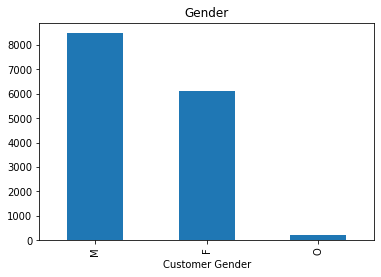

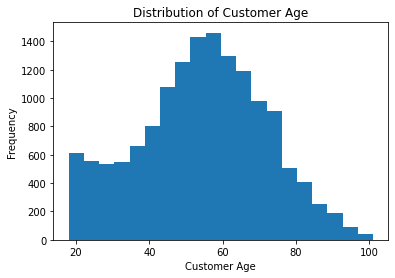

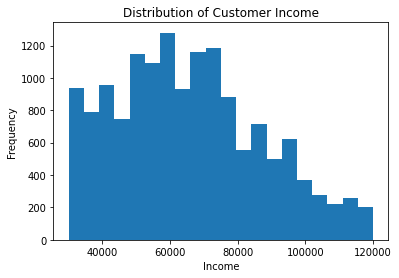

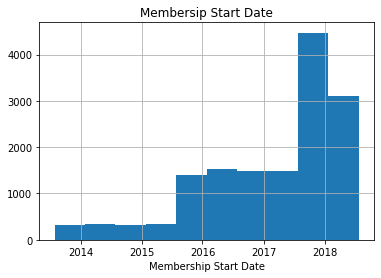

<Figure size 432x288 with 0 Axes>

In [17]:
display_customer_profile()

### Observations:

 There is a third gender O, with very few records.
 Age has quite a normal distribution , most are from 50 to 70 .
 Income is wide distribution mainly from 30,000 to 100,000.
 Memberships are mostly from 2016 and more so after 2017.

In [18]:
# explore transcript
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [19]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
# select one user and explore the transcript records
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


Value can be offer_id, reward or transaction amount. We can create columns for these.


In [21]:
transcript.shape

(306534, 4)

In [22]:
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # Get offer_id , reward and transaction amount in columns
    for k in ['reward', 'amount']:
        transcript[k] = transcript['value'].apply(lambda x: x[k] if k in x else None)
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
    transcript.drop('value', 1, inplace=True)

    return transcript
    


In [23]:
offer = clean_transcript(transcript)

In [24]:
offer.head()

,person,event,time,reward,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [25]:
# select one user and explore the transcript records
offer[offer['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

,person,event,time,reward,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,None
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,5.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,None
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,NaN,19.67,None
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,NaN,29.72,None
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,NaN,23.93,None


In [26]:
offer.shape

(306534, 6)

### Offers Taken
We are  interested in offers that were viewed and completed . For informational there might be viewed followed by a transaction. That is only time user was actively involved with offer.

In [27]:
def offers_completed(transcript):
    '''
    Get offers  recieved, viewed and completed as single entry if they follow the order.
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    views = pd.merge(transcript.loc[transcript['event'] == 'offer received', ['person', 'offer_id', 'time']],
                 transcript.loc[transcript['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='inner', suffixes=['_received', '_viewed'])

    # We have to be sure to take the reception BEFORE the view (or when there's no view)
    views = views.loc[(views['time_viewed'] >= views['time_received']) ]

    # Then we take the NEAREST reception before the view
    # We concatenate with the "missing view" dataframe portion, since aggregation results in a drop of these records
    views = pd.concat((views.groupby(['person', 'offer_id', 'time_viewed']).agg({'time_received': 'max'}).reset_index(),
                  views.loc[views['time_viewed'].isnull()]),
                  axis=0, sort=True)
    # Same reasoning joining the info about offer completion
    comp = pd.merge(views,
                transcript.loc[transcript['event'] == 'offer completed', ['person', 'offer_id', 'time', 'reward']],
                on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

    # When the completion time is AFTER the view time, we force the value to null
    comp.loc[(comp['time_viewed'].isnull()) | (comp['time_viewed'] > comp['time_completed']), ['time_completed', 'reward']] = (np.nan, np.nan)
    comp.drop_duplicates(inplace=True)

    comp = pd.concat(
    (comp.groupby(['person', 'offer_id', 'time_completed', 'reward']).agg({'time_viewed': 'max', 'time_received': 'max'}).reset_index(),
     comp.loc[comp['time_completed'].isnull()]),
    axis=0, sort=True
    )

    # Now we join the information about the relative transaction
    journey = pd.merge(comp,
                   transcript.loc[transcript['event'] == 'transaction', ['person', 'time', 'amount']],
                   left_on=['person', 'time_completed'], right_on=['person', 'time'], how='outer').rename(columns={'time': 'time_transaction'})

    # Create a reference time - received for offer, transaction otherwise
    journey['time'] = journey['time_received']
    journey.loc[journey['time'].isnull(), 'time'] = journey['time_transaction']

    # If an offer is completed twice, we have some duplicates: we have to remove them
    journey.sort_values(['person', 'offer_id', 'time', 'time_completed'], inplace=True)
    journey = journey.drop_duplicates(['person', 'offer_id', 'time'])

    journey = journey[['person', 'offer_id', 'time', 'time_received', 'time_viewed', 'time_completed', 'time_transaction', 'amount', 'reward']]


    return journey

In [28]:
offers = offers_completed(offer)

In [29]:
offers.shape

(172242, 9)

In [30]:
offers.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward
24614,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,336.0,372.0,NaN,NaN,NaN,NaN
24615,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,192.0,NaN,NaN,NaN,NaN
24616,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,456.0,NaN,NaN,NaN,NaN
24617,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,504.0,540.0,NaN,NaN,NaN,NaN
92312,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN


In [31]:
# select one user and explore the transcript records
offers[offers['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward
11591,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,6.0,132.0,132.0,19.89,5.0
79938,78afa995795e4d85b5d9ceeca43f5fef,NaN,144.0,NaN,NaN,NaN,144.0,17.78,NaN
41442,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,216.0,NaN,NaN,NaN,NaN
90985,78afa995795e4d85b5d9ceeca43f5fef,NaN,222.0,NaN,NaN,NaN,222.0,19.67,NaN
94115,78afa995795e4d85b5d9ceeca43f5fef,NaN,240.0,NaN,NaN,NaN,240.0,29.72,NaN
114555,78afa995795e4d85b5d9ceeca43f5fef,NaN,378.0,NaN,NaN,NaN,378.0,23.93,NaN
11592,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408.0,408.0,408.0,510.0,510.0,21.72,10.0
41443,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504.0,504.0,582.0,NaN,NaN,NaN,NaN
142995,78afa995795e4d85b5d9ceeca43f5fef,NaN,534.0,NaN,NaN,NaN,534.0,26.56,NaN


We need to get transaction from informational records if viewed and and transactions ocuured in 24 hours. For that we will first need to bring in data from profile and portfolio.

In [32]:
def merge_data(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
   # Join offer info
    tmp = pd.merge(transcript,
               cleaned_portfolio.rename(columns={'reward': 'pot_reward', 'id': 'offer_id'}),
               on='offer_id', how='left')

    
  # Join person info
  # We will lose some records since we dropped some profiles with no informations

    df = pd.merge(tmp,
              cleaned_profile.rename(columns={'id': 'person'}),
              how='inner', on='person')

# To better visualize the journey, let's order by the offer received time / transaction time
    df.sort_values(['person', 'time', 'offer_id'], inplace=True)
    
    # For transactions we put a specific "offer type"
    df['offer_type'].fillna('transaction', inplace=True)

    return df

In [33]:
merged_data = merge_data(offers)

In [34]:
merged_data.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,...,duration,offer_type,web,email,mobile,social,gender,age,income,member_on
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,192.0,NaN,NaN,NaN,NaN,0.0,...,3.0,informational,0.0,1.0,1.0,1.0,M,33.0,72000.0,2017-04-21
4,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,...,NaN,transaction,NaN,NaN,NaN,NaN,M,33.0,72000.0,2017-04-21
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,336.0,372.0,NaN,NaN,NaN,NaN,0.0,...,4.0,informational,1.0,1.0,1.0,0.0,M,33.0,72000.0,2017-04-21
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,456.0,NaN,NaN,NaN,NaN,5.0,...,5.0,bogo,1.0,1.0,1.0,1.0,M,33.0,72000.0,2017-04-21
5,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,...,NaN,transaction,NaN,NaN,NaN,NaN,M,33.0,72000.0,2017-04-21


In [35]:
merged_data.shape

(150435, 21)

In [36]:
# select one user and explore the transcript records
merged_data[merged_data['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,...,duration,offer_type,web,email,mobile,social,gender,age,income,member_on
69988,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,6.0,132.0,132.0,19.89,5.0,5.0,...,7.0,bogo,1.0,1.0,1.0,0.0,F,75.0,100000.0,2017-05-09
69991,78afa995795e4d85b5d9ceeca43f5fef,NaN,144.0,NaN,NaN,NaN,144.0,17.78,NaN,NaN,...,NaN,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09
69987,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,216.0,NaN,NaN,NaN,NaN,0.0,...,3.0,informational,0.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09
69992,78afa995795e4d85b5d9ceeca43f5fef,NaN,222.0,NaN,NaN,NaN,222.0,19.67,NaN,NaN,...,NaN,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09
69993,78afa995795e4d85b5d9ceeca43f5fef,NaN,240.0,NaN,NaN,NaN,240.0,29.72,NaN,NaN,...,NaN,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09
69994,78afa995795e4d85b5d9ceeca43f5fef,NaN,378.0,NaN,NaN,NaN,378.0,23.93,NaN,NaN,...,NaN,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09
69989,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408.0,408.0,408.0,510.0,510.0,21.72,10.0,10.0,...,7.0,bogo,0.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09
69990,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504.0,504.0,582.0,NaN,NaN,NaN,NaN,5.0,...,5.0,bogo,1.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09
69995,78afa995795e4d85b5d9ceeca43f5fef,NaN,534.0,NaN,NaN,NaN,534.0,26.56,NaN,NaN,...,NaN,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09


Now deal with informational records. If viewed, followed by transaction in 24 hours we consider as completed offer.
Once we have all completed entries , drop others.

In [37]:
def merge_information_transaction(df):
    '''
    Merge information record with transaction record if followed in 24 hours. 
    Also drop all other records that are not in form of completed offer
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    inf = df.loc[(df['time_viewed'].isnull() == False) | (df['time_transaction'].isnull() == False),
             ['person', 'offer_id', 'offer_type', 'time_viewed', 'time_transaction', 'amount']]
    inf['time'] = inf['time_viewed']
    inf.loc[inf['time'].isnull(), 'time'] = inf['time_transaction']
    inf.sort_values(['person', 'time', 'offer_id'], inplace=True)

    # Now we shift the info of the subsequent record
    inf['sub_offer_type'] = inf['offer_type'].shift(-1)
    inf['sub_time'] = inf['time'].shift(-1)
    inf['sub_amount'] = inf['amount'].shift(-1)
    # If the next record is relative to another customer, we put a missing
    inf.loc[inf['person'].shift(-1) != inf['person'], ['sub_offer_type', 'sub_time', 'sub_amount']] = ['', np.nan, np.nan]

    # Finally we calculate the time difference
    inf['time_diff_with_sub'] = inf['sub_time'] - inf['time_viewed']
    
    inf.loc[inf['offer_type'] == 'informational', 'info'] = 0
    inf.loc[(inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction') & (inf['time_diff_with_sub'] <= 24), 'info'] = 1

    df1 = pd.merge(df,
              inf.loc[inf['info'].isnull() == False, ['person', 'offer_id', 'time_viewed', 'info', 'sub_time', 'sub_amount']],
              how='left', on=['person', 'offer_id', 'time_viewed'])

   # Let's force time_completed equal to time_transaction for informational data
    df1.loc[df1['info'] == 1, 'time_completed'] = df1['sub_time']
    df1.loc[df1['info'] == 1, 'time_transaction'] = df1['sub_time']
    df1.loc[df1['info'] == 1, 'amount'] = df1['sub_amount']
    df1.drop('sub_time', 1, inplace=True)
    df1.drop('sub_amount', 1, inplace=True)
    
  # Now that we have offers completed for bogo, discount and informational, lets drop all others.

    #df1.dropna(subset=['time_completed'], inplace=True)

    return df1

In [38]:
merge_info = merge_information_transaction(merged_data)

In [39]:
merge_info.shape

(150435, 22)

In [40]:
# select one user and explore the transcript records
merge_info[merge_info['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,...,offer_type,web,email,mobile,social,gender,age,income,member_on,info
69987,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,6.0,132.0,132.0,19.89,5.0,5.0,...,bogo,1.0,1.0,1.0,0.0,F,75.0,100000.0,2017-05-09,NaN
69988,78afa995795e4d85b5d9ceeca43f5fef,NaN,144.0,NaN,NaN,NaN,144.0,17.78,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN
69989,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,216.0,222.0,222.0,19.67,NaN,0.0,...,informational,0.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09,1.0
69990,78afa995795e4d85b5d9ceeca43f5fef,NaN,222.0,NaN,NaN,NaN,222.0,19.67,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN
69991,78afa995795e4d85b5d9ceeca43f5fef,NaN,240.0,NaN,NaN,NaN,240.0,29.72,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN
69992,78afa995795e4d85b5d9ceeca43f5fef,NaN,378.0,NaN,NaN,NaN,378.0,23.93,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN
69993,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408.0,408.0,408.0,510.0,510.0,21.72,10.0,10.0,...,bogo,0.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09,NaN
69994,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504.0,504.0,582.0,NaN,NaN,NaN,NaN,5.0,...,bogo,1.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09,NaN
69995,78afa995795e4d85b5d9ceeca43f5fef,NaN,534.0,NaN,NaN,NaN,534.0,26.56,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN


### Cleaned completed offers set
- Now we have a cleaned completed offers. Lets save it



In [41]:
# Write output
merge_info.to_csv('./data/cleaned_completed_offers.csv', index=False)